# IMU Data Classification

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from helper_filter import *

## Filter data
### Extract data tables

In [2]:
# Read the raw data from each target action and store them in a list
lqw_raw = load_data("./IMU_Data/LGW")
ramp_ascend_raw = load_data("./IMU_Data/Ramp_ascend")
ramp_descend_raw = load_data("./IMU_Data/Ramp_descend")
sit_to_stand_raw = load_data("./IMU_Data/Sit_to_stand")
stand_to_sit_raw = load_data("./IMU_Data/Stand_to_sit")

In [3]:
# Preview some of the data to check format
lqw_raw[0].head()

,Thigh_R_Timestamp,Thigh_R_Gyroscope_X,Thigh_R_Gyroscope_Y,Thigh_R_Gyroscope_Z,Thigh_R_Accelerometer_X,Thigh_R_Accelerometer_Y,Thigh_R_Accelerometer_Z,Thigh_R_Magnetometer_X,Thigh_R_Magnetometer_Y,Thigh_R_Magnetometer_Z,...,Pelvis_Gyroscope_Y,Pelvis_Gyroscope_Z,Pelvis_Accelerometer_X,Pelvis_Accelerometer_Y,Pelvis_Accelerometer_Z,Pelvis_Magnetometer_X,Pelvis_Magnetometer_Y,Pelvis_Magnetometer_Z,Annotation_Pulse,Annotation_Level
0,241787.1094,0.5345,1.2220,-0.8404,-2.1075,9.1086,3.2014,-0.2819,-0.7146,-0.2299,...,0.5600,0.0212,-0.1209,9.6397,-1.0211,-0.1688,-0.6494,-0.1636,0.0,0.0
1,241796.8750,0.5345,1.2220,-0.8404,-2.1090,9.0322,3.0518,-0.2819,-0.7223,-0.2321,...,0.5600,0.0212,-0.1209,9.7162,-1.0218,-0.1725,-0.6264,-0.1728,0.0,0.0
2,241806.6406,-0.2664,0.2175,-1.1036,-2.1872,9.1850,3.2015,-0.2800,-0.7049,-0.2148,...,0.5600,0.0212,-0.1209,9.7926,-1.0226,-0.1781,-0.6533,-0.1751,0.0,0.0
3,241816.4062,-0.2664,0.2175,-1.1036,-2.1082,9.1850,3.1255,-0.2876,-0.7049,-0.2169,...,1.0746,-0.0255,-0.2044,9.7123,-1.4106,-0.1744,-0.6513,-0.1728,0.0,0.0
4,241826.1719,-0.2664,0.2175,-1.1036,-2.0293,9.0322,3.0510,-0.2743,-0.6893,-0.2169,...,1.0746,-0.0255,-0.2793,9.7934,-0.9448,-0.1725,-0.6284,-0.1728,0.0,0.0


array([[<AxesSubplot: title={'center': 'Thigh_R_Timestamp'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Gyroscope_X'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Gyroscope_Y'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Gyroscope_Z'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Accelerometer_X'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Accelerometer_Y'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Accelerometer_Z'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Magnetometer_X'}>],
       [<AxesSubplot: title={'center': 'Thigh_R_Magnetometer_Y'}>,
        <AxesSubplot: title={'center': 'Thigh_R_Magnetometer_Z'}>,
        <AxesSubplot: title={'center': 'Shank_R_Timestamp'}>,
        <AxesSubplot: title={'center': 'Shank_R_Gyroscope_X'}>,
        <AxesSubplot: title={'center': 'Shank_R_Gyroscope_Y'}>,
        <AxesSubplot: title={'center': 'Shank_R_Gyroscope_Z'}>,
        <AxesSubplot: title={'center': 'Shank_R_Accelerometer_X'}>,
        <AxesSubpl

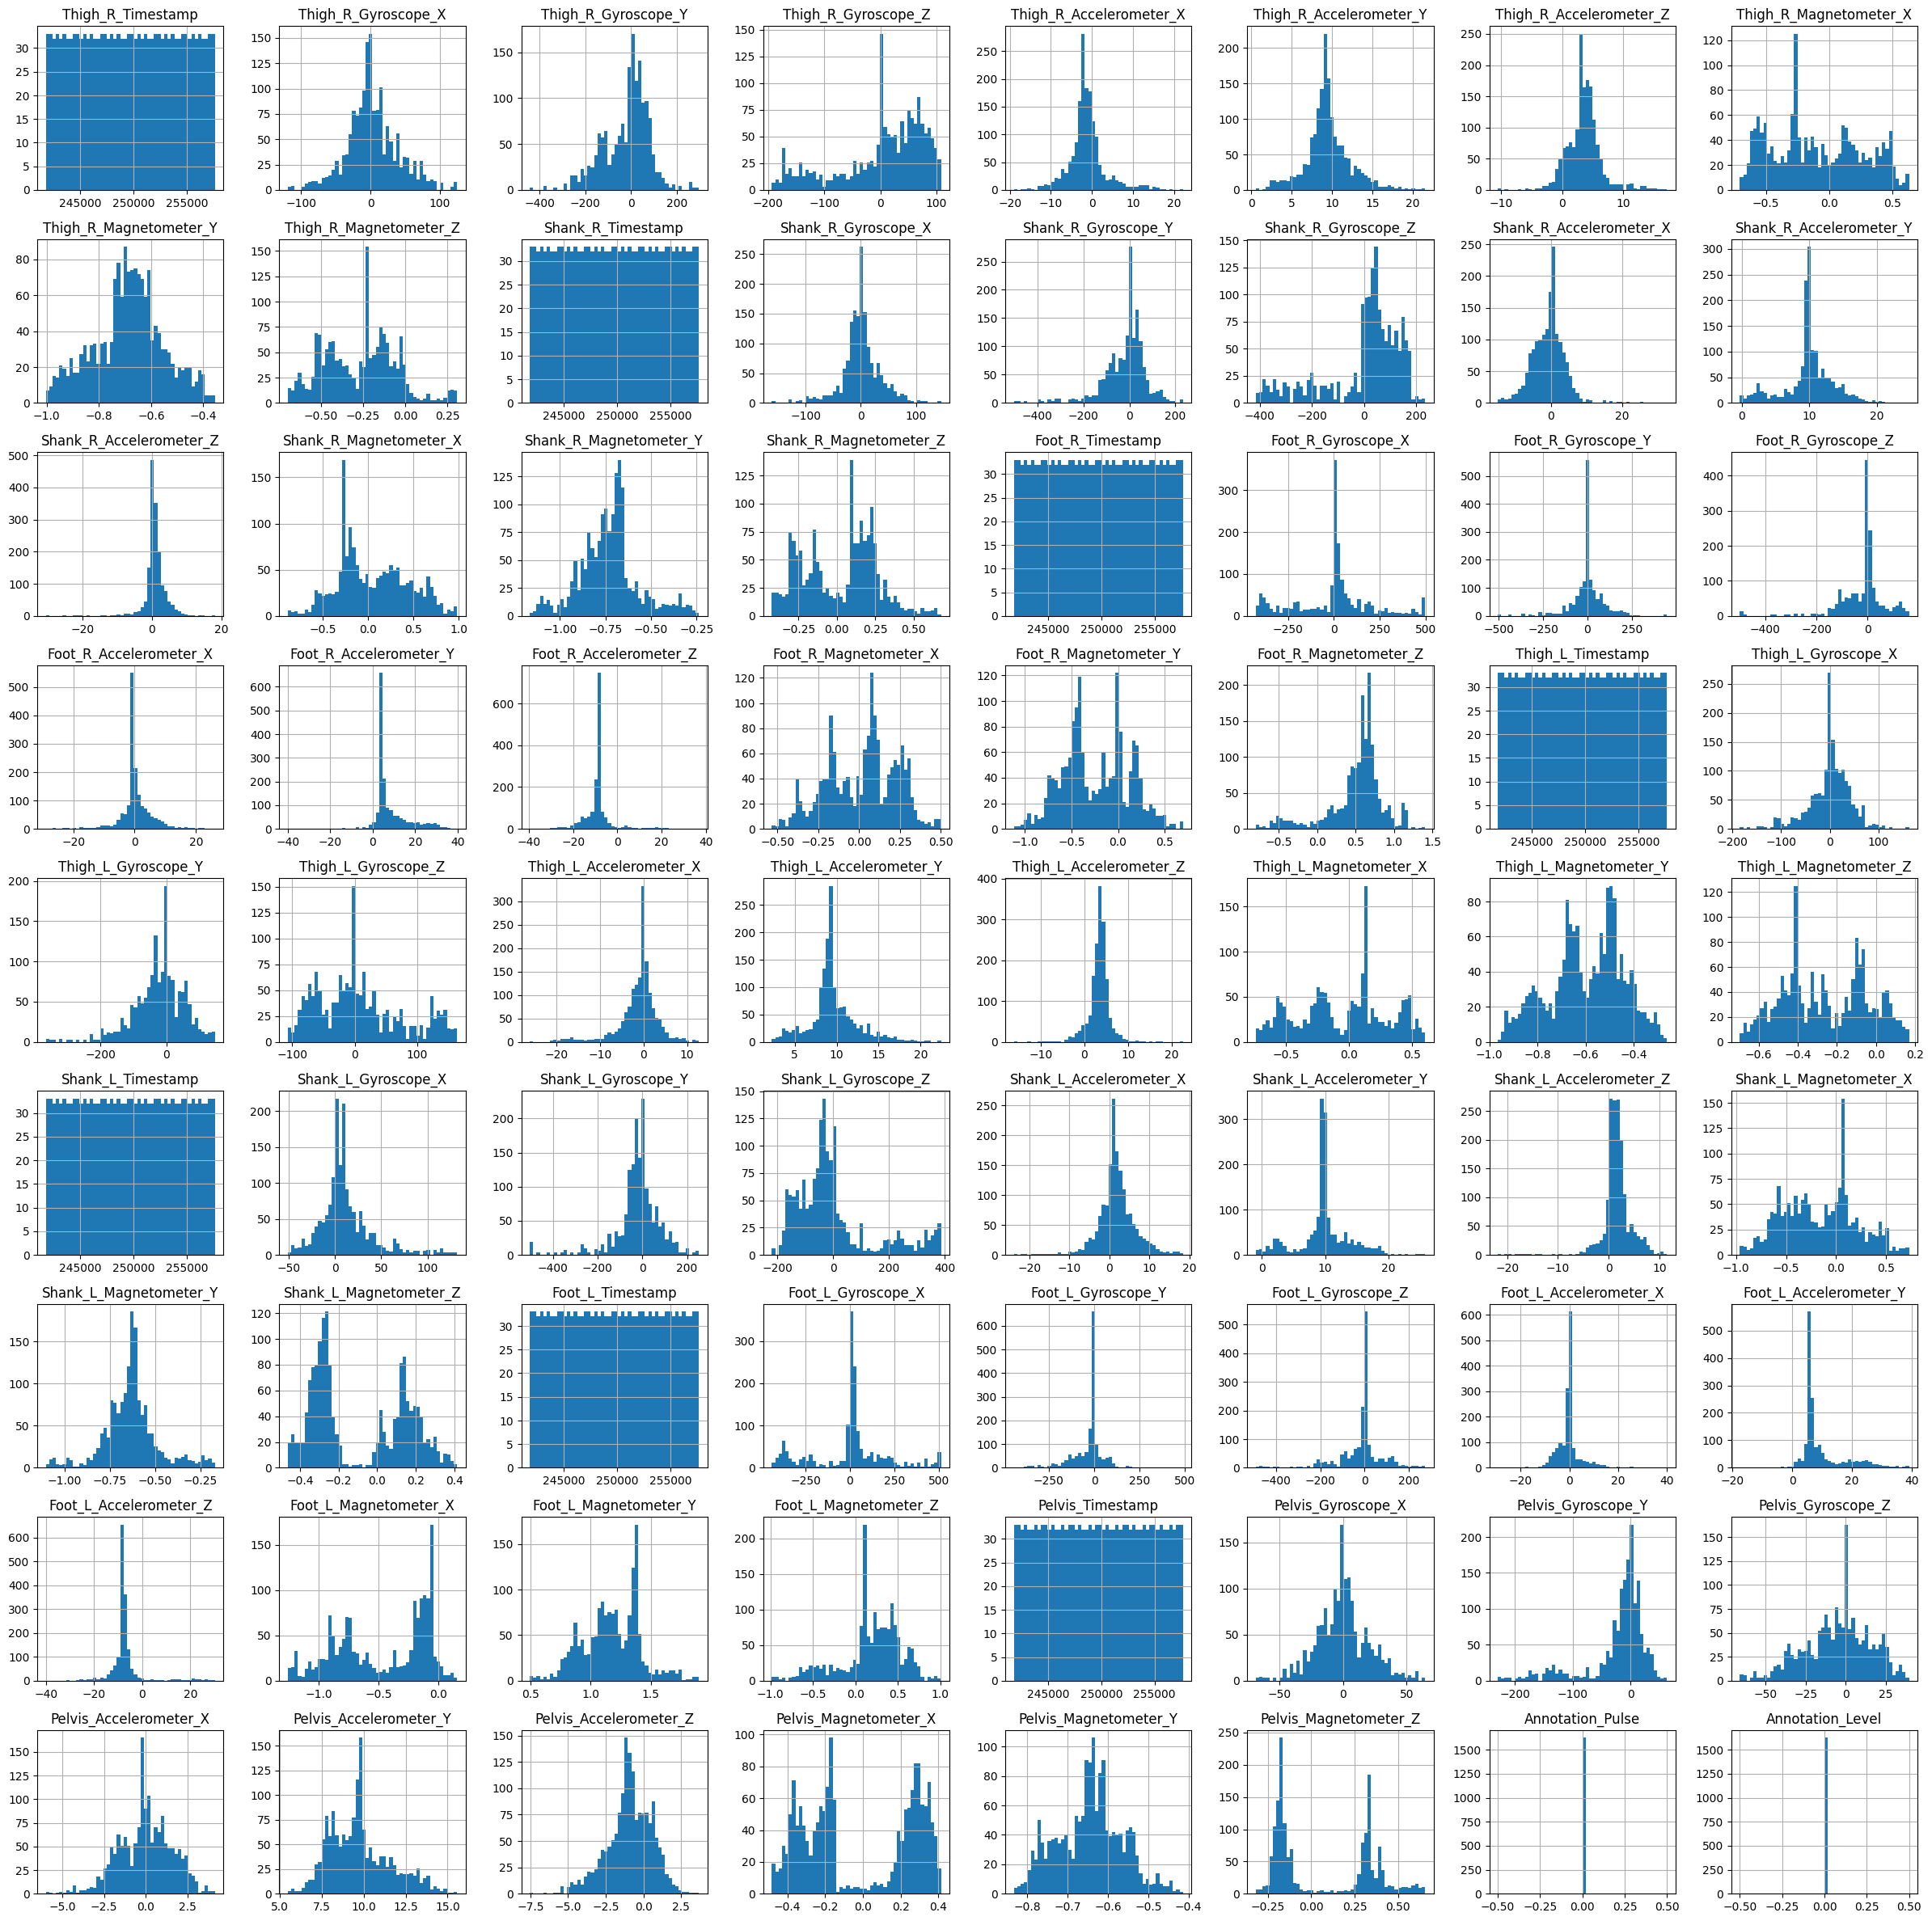

In [4]:
# Plot histograms to visualize all data
%matplotlib inline
lqw_raw[0].hist(bins=50,figsize=(30,30))

### Remove unwanted columns

In [ ]:
# Check number of columns in each dataframe


## Preprocess data
### Apply filtering

In [5]:
# TODO 

### Apply the slinding window technique

In [6]:
# TODO

## Train models
### ANN

In [7]:
# TODO

### SVM

In [8]:
# TODO

### CNN

In [9]:
# TODO

### Comparison

In [10]:
# TODO